# We need to classify Japanese Whisky reviews as POSITIVE or NEGATIVE 

The only problem is.. we have 1100 reviews! UGH! Perhaps we can label the first 200 reviews and pass the rest of the work off to a Naive Bayes classifier.

To start, I labeled the first 200 reviews as positive or negative and will use those to train our Naive Bayes TF-IDF model. Then I'll evaluate the model on the training dataset using a confusion matrix. Finally, I'll use the model to classify the remaining 900 reviews.

Note: During the first iteration of this algorithm, I didn't use custom sentiment words (i.e. I simply removed the punctuation and stopwords and classified reviews using TFIDF on all remaining words). This resulted in ALL of the first 200 reviews being classified as POSITIVE. This is likely due to the fact that our training dataset is so small. To correct this, I added some custom sentiment words for the TFIDF Naive Bayes algorithm to focus on.

# Let's get familiar with our data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./archive/labeled_japanese_whisky.csv')

In [3]:
df.head()

,ID,Bottle_name,Brand,Title,DESC,Label
0,1,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Overpriced dissapointment,dull taste high price no finish over-hyped ...,1.0
1,2,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Delicious,delicious sugared red fruits and sweet with ...,2.0
2,3,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Good for beginners. i know cos i am a beginner,i am not a whisky expert but i really love the...,2.0
3,4,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Yamazaki Tutorial,"this is a terrible yamazaki very young, unsh...",1.0
4,5,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Very Nice,first time and i like it - fresh but not thin ...,2.0


In [4]:
df.tail()

,ID,Bottle_name,Brand,Title,DESC,Label
1117,1126,Nikka 1995 Single Cask Coffey Grain,Nikka,Great whisky,really enjoyed the flavour of this whisky g...,NaN
1118,1127,Nikka 1995 Single Cask Coffey Grain,Nikka,Phenomenal.,given the slightly racist tone to the guy at t...,NaN
1119,1128,Nikka 1995 Single Cask Coffey Grain,Nikka,Great.,the particular distillation process makes this...,NaN
1120,1129,Nikka 1995 Single Cask Coffey Grain,Nikka,"It s whisky, not wine",that s probably why the previous poster though...,NaN
1121,1130,Nikka 1995 Single Cask Coffey Grain,Nikka,Japs dont know anything about making wine,its like buying a bottle of grey goose thinkin...,NaN


In [5]:
print(df.dtypes)

ID               int64
Bottle_name     object
Brand           object
Title           object
DESC            object
Label          float64
dtype: object


## Clean our data

In [6]:
last_labeled_index = 200 # how many labeled reviews we have

In [7]:
duplicates = df.duplicated(subset=['DESC'])
print(duplicates)

0       False
1       False
2       False
3       False
4       False
        ...  
1117    False
1118    False
1119    False
1120    False
1121    False
Length: 1122, dtype: bool


In [8]:
list_of_duplicates = list(duplicates)

In [9]:
duplicate_rows = []
for i in range(len(list_of_duplicates)):
    if list_of_duplicates[i] is True:
        duplicate_rows.append(i)
print(duplicate_rows)

[186, 296, 309, 314, 327, 331, 337, 509, 556, 559, 1012, 1031]


Drop duplicate rows from our dataframe

In [10]:
df.shape

(1122, 6)

In [11]:
df = df.drop(duplicate_rows)
df.reset_index(drop=True, inplace=True)
df.shape

(1110, 6)

Convert labels to integer format

In [12]:
df['Label'] = df['Label'].fillna(0).astype(int)
df.head()

,ID,Bottle_name,Brand,Title,DESC,Label
0,1,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Overpriced dissapointment,dull taste high price no finish over-hyped ...,1
1,2,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Delicious,delicious sugared red fruits and sweet with ...,2
2,3,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Good for beginners. i know cos i am a beginner,i am not a whisky expert but i really love the...,2
3,4,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Yamazaki Tutorial,"this is a terrible yamazaki very young, unsh...",1
4,5,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Very Nice,first time and i like it - fresh but not thin ...,2


Remove punctuation and irrelevant words from our data

In [13]:
sentiment_word_arr = ['nice', 'delicious', 'great', 'amazing', 'amazingly', 'yummy', 
                   'good', 'wow', 'enjoy', 'enjoyed', 'enjoyable', 'excellent', 
                   'brilliant', 'love', 'like', 'loved', 'liked', 'best', 'pleased',
                   'nasty', 'gross', 'ripoff', 'rip-off', 'terrible', 'disgusting', 
                   'disappointing', 'disappointment', 'disappointed', 'worst', 'dull', 
                   'overpriced', 'unworthy', 'hype', 'expensive', 'flavorful', 'smooth', 
                   'cheap', 'awful', 'waste']

In [14]:
import string
def clean_text(description):
    valid_chars = [char for char in description if char not in string.punctuation]
    new_desc = ''.join(valid_chars)
    return [word.lower() for word in new_desc.split() if word.lower() in sentiment_word_arr]

We'll combine the words from our review title and review description so we have more data to train our model with

In [15]:
data_for_cv = df.iloc[:,3].apply(clean_text) + df.iloc[:,4].apply(clean_text) #cv is our count vectorizer
data_for_cv

0                       [overpriced, dull, disappointing]
1                                  [delicious, delicious]
2       [good, love, like, enjoyed, expensive, enjoyable]
3       [terrible, good, excellent, good, overpriced, ...
4                                      [nice, like, like]
                              ...                        
1105                              [great, enjoyed, great]
1106                                                   []
1107                                       [great, great]
1108                                                   []
1109                                         [like, like]
Length: 1110, dtype: object

Let's add the sentiment words to our dataframe so we can do cool stuff with them in SQL

In [16]:
df2 = pd.DataFrame(columns=['Sentiment_Words'])
for i in range(0, df.shape[0]): 
    df2 = df2.append({'Sentiment_Words' : ' '.join(data_for_cv[i])}, ignore_index=True)
df2

,Sentiment_Words
0,overpriced dull disappointing
1,delicious delicious
2,good love like enjoyed expensive enjoyable
3,terrible good excellent good overpriced great
4,nice like like
...,...
1105,great enjoyed great
1106,
1107,great great
1108,


In [17]:
df = pd.concat([df, df2], axis=1)
df.head()

,ID,Bottle_name,Brand,Title,DESC,Label,Sentiment_Words
0,1,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Overpriced dissapointment,dull taste high price no finish over-hyped ...,1,overpriced dull disappointing
1,2,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Delicious,delicious sugared red fruits and sweet with ...,2,delicious delicious
2,3,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Good for beginners. i know cos i am a beginner,i am not a whisky expert but i really love the...,2,good love like enjoyed expensive enjoyable
3,4,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Yamazaki Tutorial,"this is a terrible yamazaki very young, unsh...",1,terrible good excellent good overpriced great
4,5,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Very Nice,first time and i like it - fresh but not thin ...,2,nice like like


Split our data into two datasets (one labeled, one not labeled)

In [18]:
labeled_df = df.iloc[:last_labeled_index] 
unlabeled_df = df.iloc[last_labeled_index:]
labeled_df

,ID,Bottle_name,Brand,Title,DESC,Label,Sentiment_Words
0,1,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Overpriced dissapointment,dull taste high price no finish over-hyped ...,1,overpriced dull disappointing
1,2,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Delicious,delicious sugared red fruits and sweet with ...,2,delicious delicious
2,3,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Good for beginners. i know cos i am a beginner,i am not a whisky expert but i really love the...,2,good love like enjoyed expensive enjoyable
3,4,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Yamazaki Tutorial,"this is a terrible yamazaki very young, unsh...",1,terrible good excellent good overpriced great
4,5,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Very Nice,first time and i like it - fresh but not thin ...,2,nice like like
...,...,...,...,...,...,...,...
195,205,Yamazaki 18 Year Old,Yamazaki,David Yeh,one of the best single malt in the world pro...,2,best
196,206,Yamazaki 18 Year Old,Yamazaki,"Decent, but not remarkabke",good but just that not amazing i ve had bet...,1,good amazing
197,207,Yamazaki 18 Year Old,Yamazaki,AMAZING !!!!,best whisky under $400 i ve had i paid way t...,2,amazing best great
198,208,Yamazaki 18 Year Old,Yamazaki,Yamazaki 18,the best whisky in the world,2,best


In [19]:
labeled_df_words = labeled_df['Sentiment_Words']
labeled_df_labels = labeled_df["Label"]

# Reformat our data

Because we're using the same model on 2 different sets of data (first 200 reviews VS following 900), we'll want to ensure both bags of words (bow) have the same encoding.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
encoded_vocabulary = CountVectorizer().fit(sentiment_word_arr)
encoded_vocabulary.vocabulary_

{'nice': 27,
 'delicious': 6,
 'great': 19,
 'amazing': 0,
 'amazingly': 1,
 'yummy': 39,
 'good': 18,
 'wow': 38,
 'enjoy': 12,
 'enjoyed': 14,
 'enjoyable': 13,
 'excellent': 15,
 'brilliant': 4,
 'love': 24,
 'like': 22,
 'loved': 25,
 'liked': 23,
 'best': 3,
 'pleased': 30,
 'nasty': 26,
 'gross': 20,
 'ripoff': 32,
 'rip': 31,
 'off': 28,
 'terrible': 34,
 'disgusting': 10,
 'disappointing': 8,
 'disappointment': 9,
 'disappointed': 7,
 'worst': 37,
 'dull': 11,
 'overpriced': 29,
 'unworthy': 35,
 'hype': 21,
 'expensive': 16,
 'flavorful': 17,
 'smooth': 33,
 'cheap': 5,
 'awful': 2,
 'waste': 36}

In [21]:
bow_for_labeled_reviews = encoded_vocabulary.transform(labeled_df_words)

Next, let's calculate each words weighted importantce by using TFIDF

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(bow_for_labeled_reviews)

labeled_tfidf=tfidf_transformer.transform(bow_for_labeled_reviews)

# Train and evaluate our model

Train our model on the labeled (first 200) reviews

In [23]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(labeled_tfidf, labeled_df_labels)

In [24]:
all_predictions = model.predict(labeled_tfidf)
all_predictions

array([1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(labeled_df_labels, all_predictions)

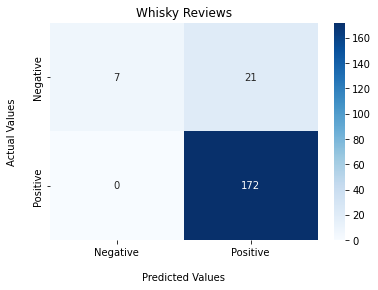

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt


ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_title('Whisky Reviews');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

plt.show()

In [27]:
print('Accuracy of the algorithm is: {}'.format(accuracy_score(labeled_df_labels, all_predictions)))

Accuracy of the algorithm is: 0.895


### Some things to consider!

At first glance, 90% accuracy isn't bad. However, we're incorrectly classifying 70% of our negative reviews! So there is definitely room for improvement.

We could:
- Try labeling more reviews so our algorithm has more "negative review" data to train with.
- Browse through our negative reviews to find more words with "negative sentiment" and add them to our sentiment_words list.
- Test it against a different ML model (ex: neural network, decision tree, or logistic regression)

Note: Another good idea would be to label 50 more reviews (that we haven't used for training our model) and evaluate how well our trained model performs on new data. But because we're making our sentiment classifier in order to spend LESS time labeling the 1100 reviews, we'll just proceed with our current data.

# Run our model on the remaining 900 reviews

In [28]:
unlabeled_df_words = unlabeled_df['Sentiment_Words']
unlabeled_df_labels = unlabeled_df["Label"]

In [29]:
unlabeled_desc_bow = encoded_vocabulary.transform(unlabeled_df_words)
tfidf_transformer = TfidfTransformer().fit(unlabeled_desc_bow)

unlabeled_desc_tfidf=tfidf_transformer.transform(unlabeled_desc_bow)

In [30]:
new_predictions = model.predict(unlabeled_desc_tfidf)

In [31]:
positive_predictions = list(new_predictions).count(2)
negative_predictions = list(new_predictions).count(1)
print("positive reviews:{} negative reviews:{}".format(positive_predictions, negative_predictions))

positive reviews:905 negative reviews:5


In [32]:
predicted_labels = list(all_predictions) + list(new_predictions)

In [33]:
df['Predicted Label'] = pd.Series(predicted_labels)
df

,ID,Bottle_name,Brand,Title,DESC,Label,Sentiment_Words,Predicted Label
0,1,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Overpriced dissapointment,dull taste high price no finish over-hyped ...,1,overpriced dull disappointing,1
1,2,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Delicious,delicious sugared red fruits and sweet with ...,2,delicious delicious,2
2,3,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Good for beginners. i know cos i am a beginner,i am not a whisky expert but i really love the...,2,good love like enjoyed expensive enjoyable,2
3,4,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Yamazaki Tutorial,"this is a terrible yamazaki very young, unsh...",1,terrible good excellent good overpriced great,2
4,5,The Yamazaki Single Malt Whisky - Distiller’s ...,Yamazaki,Very Nice,first time and i like it - fresh but not thin ...,2,nice like like,2
...,...,...,...,...,...,...,...,...
1105,1126,Nikka 1995 Single Cask Coffey Grain,Nikka,Great whisky,really enjoyed the flavour of this whisky g...,0,great enjoyed great,2
1106,1127,Nikka 1995 Single Cask Coffey Grain,Nikka,Phenomenal.,given the slightly racist tone to the guy at t...,0,,2
1107,1128,Nikka 1995 Single Cask Coffey Grain,Nikka,Great.,the particular distillation process makes this...,0,great great,2
1108,1129,Nikka 1995 Single Cask Coffey Grain,Nikka,"It s whisky, not wine",that s probably why the previous poster though...,0,,2


In [34]:
df.to_csv("./archive/Japanese_Whisky_Predictions.csv")

Let's check out our data in SQL!

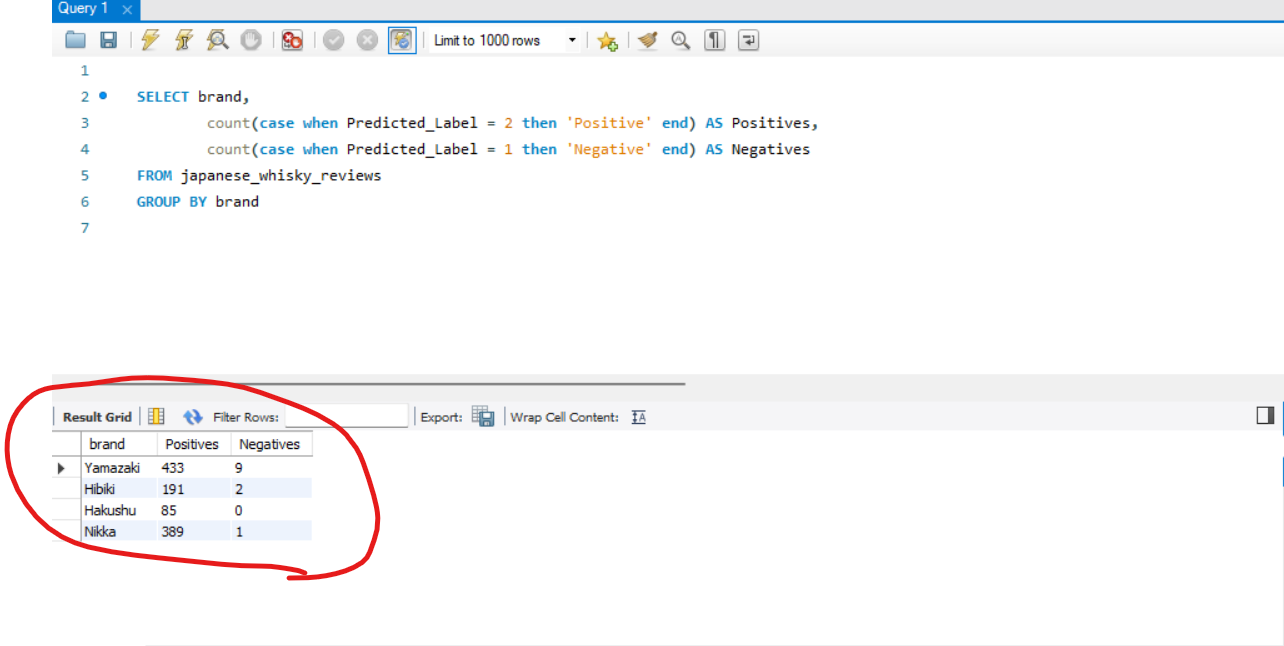

Although Hakushu has no negative reviews, I'd argue that it's due to limited data and that Nikka is most popular!